In [82]:
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
groups_folder_path = "./sample_data/image/dachshund/"
groups_folder_path1 = "./sample_data/image/ducks/"
groups_folder_path2 = "./sample_data/image/fish/"


def imglist(groups_folder_path_name):
    img_list = []
    for x in os.listdir(groups_folder_path_name):
      if x != '.ipynb_checkpoints':
        image_filename = groups_folder_path_name + x
        img = Image.open(image_filename)
        size = (512, 512)
        img = img.resize(size)
        img = np.array(img)
        img_list.append(img)
    return img_list

a = imglist(groups_folder_path)
b = imglist(groups_folder_path1)
c = imglist(groups_folder_path2)
print(len(a), len(b), len(c))

X = np.concatenate((a,b,c), axis = 0)

num_classes = 3
Y = []
for i in range(3):
  label = [0 for i in range(num_classes)]
  label[i] = 1
  for _ in range(21):
     Y.append(label)

Y = np.asarray(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X.shape, Y.shape)
X_test.shape, Y_test.shape


21 21 21
(63, 512, 512, 3) (63, 3)


((16, 512, 512, 3), (16, 3))

[0 1 0]
[0 0 1]
[0 1 0]
[0 0 1]
[0 0 1]


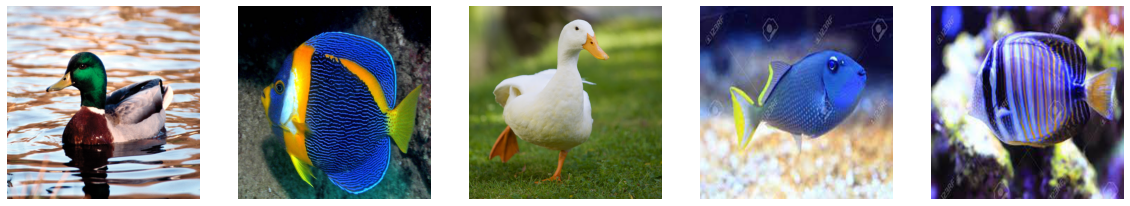

In [83]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(X_train[i])
    ax[i].axis('off')
    print(Y_train[i])

In [84]:
def dep_bn(inputs, filter: int, kernel: int, stride : int):

  y = tf.keras.layers.Conv2D(filters = filter, kernel_size= kernel, strides= stride, padding= 'same')(inputs)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  relu = tf.nn.relu6(bn)
  
  return relu 


def Inverted_residual_block(x, filter : int, strides = int):


    #pointwise
    y = tf.keras.layers.Conv2D(filters = filter, kernel_size= 1, strides = strides, padding= 'same')(x)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    y_p = tf.nn.relu6(bn)
    
    
    #depthwise
    y = tf.keras.layers.DepthwiseConv2D(kernel_size= 3, strides= strides, padding= 'same', depth_multiplier = 1)(y_p)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    y_d = tf.nn.relu6(bn)


    #pointwise
    y = tf.keras.layers.Conv2D(filters = filter, kernel_size= 1, strides=strides, padding= 'same')(y_d)
    out = tf.keras.layers.BatchNormalization(axis = 1)(y)


    if strides == 1:
        if x.shape[3] != filter : 
           x = tf.keras.layers.Conv2D(filters = filter, kernel_size = 1, strides = strides, padding = "same")(x)
        out  = tf.keras.layers.Add()([x, out])

    return out




In [86]:
def create_mobilenetV2(inputs):

   x = dep_bn(inputs, 32, 3, 2)
   x = Inverted_residual_block(inputs, 16, 1)
   x = Inverted_residual_block(x, 24, 2)
   x = Inverted_residual_block(x, 24, 2)
   x = Inverted_residual_block(x, 32, 2)
   x = Inverted_residual_block(x, 32, 2)
   x = Inverted_residual_block(x, 32, 2)
   x = Inverted_residual_block(x, 64, 2)
   x = Inverted_residual_block(x, 64, 2)
   x = Inverted_residual_block(x, 64, 2)
   x = Inverted_residual_block(x, 64, 2)
   x = Inverted_residual_block(x, 96, 1)
   x = Inverted_residual_block(x, 96, 1)
   x = Inverted_residual_block(x, 96, 1)
   x = Inverted_residual_block(x, 160, 2)
   x = Inverted_residual_block(x, 160, 2)
   x = Inverted_residual_block(x, 160, 2)
   x = dep_bn(x, 320, 1, 1)
   
   
   t = tf.keras.layers.AveragePooling2D(1)(x)
   t = tf.keras.layers.Flatten()(t)
   outputs = tf.keras.layers.Dense(3, activation='softmax')(t)
   return outputs

   

In [87]:
inputs = tf.keras.Input(shape=(X_train[0].shape[0], X_train[0].shape[0],3))
outputs = create_mobilenetV2(inputs)

model = tf.keras.Model(inputs, outputs)
EPOCHS = 40
INIT_LR = 1e-3
BS = 5
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [88]:
#model.summary()
model.fit(
    X_train,
    Y_train,
    epochs=40,
    verbose=1,
    validation_data=(X_test, Y_test),
    batch_size=5
)

Epoch 1/40
10/10 [==============================] - 7s 280ms/step - loss: 1.4059 - accuracy: 0.3830 - val_loss: 1.0944 - val_accuracy: 0.5000
Epoch 2/40
10/10 [==============================] - 2s 181ms/step - loss: 1.1366 - accuracy: 0.3191 - val_loss: 1.0931 - val_accuracy: 0.5000
Epoch 3/40
10/10 [==============================] - 2s 178ms/step - loss: 1.1454 - accuracy: 0.3404 - val_loss: 1.0917 - val_accuracy: 0.5000
Epoch 4/40
10/10 [==============================] - 2s 180ms/step - loss: 1.0856 - accuracy: 0.3404 - val_loss: 1.0944 - val_accuracy: 0.2500
Epoch 5/40
10/10 [==============================] - 2s 186ms/step - loss: 0.9263 - accuracy: 0.6596 - val_loss: 1.0976 - val_accuracy: 0.2500
Epoch 6/40
10/10 [==============================] - 2s 179ms/step - loss: 0.8369 - accuracy: 0.7234 - val_loss: 1.1134 - val_accuracy: 0.2500
Epoch 7/40
10/10 [==============================] - 2s 187ms/step - loss: 0.8788 - accuracy: 0.6383 - val_loss: 1.1325 - val_accuracy: 0.2500
Epoch 

In [110]:
predictions = model.predict(X_train[0])
predictions

ValueError: ignored

In [107]:
filename = "./sample_data/test/"
test = np.asarray(imglist(filename))


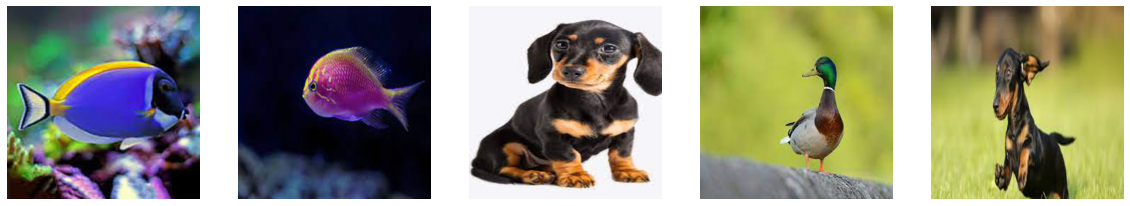

In [94]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(test[i])
    ax[i].axis('off')
 

In [95]:
def output_one_hot(prediction) :
    
   
    i = np.argmax(prediction)
    label_output = [0 for i in range(num_classes)]
    label_output[i] = 1
    return label_output

In [96]:
onehot_output = []
for pred in predictions:
    
    onehot_output.append(output_one_hot(pred))
print(onehot_output)

[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]
